# Introduction

QA plots for the single particle in calorimeters and reconstructed as calorimetric jet objects

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
# initialization

display(Markdown('pyROOT env check:'))

import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

pyROOT env check:

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.1`

In [4]:
import subprocess

try:
    git_url = \
        subprocess.run(['git','remote','get-url','origin'], stdout=subprocess.PIPE)\
        .stdout.decode('utf-8').strip()\
        .replace('git@github.com:','https://github.com/')

    display(Markdown(f"View the source code repository at {git_url}"))
except: # catch *all* exceptions
    #     well do nothing
    pass


View the source code repository at https://github.com/sPHENIX-Collaboration/QA-gallery.git

In [5]:
display(Markdown('Some further details about the QA run, if executed under the Jenkins CI:'))

checkrun_repo_commit = os.getenv("checkrun_repo_commit")
if checkrun_repo_commit is not None:
    display(Markdown(f"* The commit being checked is {checkrun_repo_commit}"))
        
ghprbPullLink = os.getenv("ghprbPullLink")
if ghprbPullLink is not None:
    display(Markdown(f"* Link to the pull request: {ghprbPullLink}"))

BUILD_URL =  os.getenv("BUILD_URL")
if BUILD_URL is not None:
    display(Markdown(f"* Link to the build: {BUILD_URL}"))

RUN_ARTIFACTS_DISPLAY_URL = os.getenv("RUN_ARTIFACTS_DISPLAY_URL")
if RUN_ARTIFACTS_DISPLAY_URL is not None:
    display(Markdown(f"* Download the QA ROOT files: {RUN_ARTIFACTS_DISPLAY_URL}"))

JENKINS_URL  = os.getenv("JENKINS_URL")
if JENKINS_URL is not None:
    display(Markdown(f"Automatically generated by [sPHENIX Jenkins continuous integration]({JENKINS_URL}) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)"))

Some further details about the QA run, if executed under the Jenkins CI:


# Initialization

In [6]:
%%cpp -d

#include "QA_Draw_Utility.C"

#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [7]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");

// test sPHENIX lib load
// gSystem->Load("libg4eval.so");

// test libs
// gSystem->ListLibraries();

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [8]:

qa_file_name_new = os.getenv("qa_file_name_new")
if qa_file_name_new is None:
    qa_file_name_new = "G4sPHENIX_e-_pT4_Sum15_qa.root"
    display(Markdown(f"`qa_file_name_new` env not set. use the default `qa_file_name_new={qa_file_name_new}`"))

qa_file_name_ref = os.getenv("qa_file_name_ref")
if qa_file_name_ref is None:
    qa_file_name_ref = "reference/G4sPHENIX_e-_pT4_Sum15_qa.root"
    display(Markdown(f"`qa_file_name_ref` env not set. use the default `qa_file_name_ref={qa_file_name_ref}`"))
elif qa_file_name_ref == 'None':
    qa_file_name_ref = None
    display(Markdown(f"`qa_file_name_ref` = None and we are set to not to use the reference histograms"))
    


`qa_file_name_new` env not set. use the default `qa_file_name_new=G4sPHENIX_e-_pT4_Sum15_qa.root`

`qa_file_name_ref` env not set. use the default `qa_file_name_ref=reference/G4sPHENIX_e-_pT4_Sum15_qa.root`

In [9]:
# qa_file_new = ROOT.TFile.Open(qa_file_name_new);

# assert qa_file_new.IsOpen()
# qa_file_new.ls()
display(Markdown(f"Openning QA file at `{qa_file_name_new}`"))
ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_new = new TFile(\"{qa_file_name_new}\");")
ROOT.gInterpreter.ProcessLine(f"const char * qa_file_name_new = \"{qa_file_name_new}\";")

if qa_file_name_ref is not None:
#     qa_file_ref = ROOT.TFile.Open(qa_file_name_ref);

#     assert qa_file_ref.IsOpen()
    display(Markdown(f"Openning QA reference file at `{qa_file_name_ref}`"))
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = new TFile(\"{qa_file_name_ref}\");")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = \"{qa_file_name_ref}\";")
else:
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = nullptr;")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = nullptr;")


Openning QA file at `G4sPHENIX_e-_pT4_Sum15_qa.root`

Openning QA reference file at `reference/G4sPHENIX_e-_pT4_Sum15_qa.root`

In [10]:
%%cpp

if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

// list inputs histograms if needed
// qa_file_new ->ls();

//TFile *qa_file_ref = NULL;
//if (qa_file_name_ref)
//{
//    qa_file_ref = new TFile(qa_file_name_ref);
//  
//    if (qa_file_ref == nullptr) 
//    {
//        cout <<"Error, can not open QA root file"<<qa_file_name_ref<<endl;
//        exit(1);
//    }
//}

In [11]:
%%cpp -d

// Jet utility functions


void QA_Draw_Jet_Spectrum(
    const char *jet = "h_QAG4SimJet_AntiKt_Truth_r07")
{

  // obtain normalization
  double Nevent_new = 1;
  double Nevent_ref = 1;

  if (qa_file_new)
  {
    TH1D *h_norm = (TH1D *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Normalization"), "TH1D");
    assert(h_norm);

    Nevent_new = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }
  if (qa_file_ref)
  {
    TH1D *h_norm = (TH1D *) qa_file_ref->GetObjectChecked(
        TString(jet) + TString("_Normalization"), "TH1D");
    assert(h_norm);

    Nevent_ref = h_norm->GetBinContent(h_norm->GetXaxis()->FindBin("Event"));
  }

  TCanvas *c1 = new TCanvas(TString("QA_Draw_Jet_Spectrum_") + TString(jet),
                            TString("QA_Draw_Jet_Spectrum_") + TString(jet), 1800, 1000);
  c1->Divide(4, 2);
  int idx = 1;
  TPad *p;

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_eta"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_eta"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_phi"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_phi"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_Et"), "TH1F");
    assert(h_new);

    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_Et"), "TH1F");
      assert(h_ref);

      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_Mass"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_Mass"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogx();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_CompSize"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_CompSize"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_CEMC_Ratio"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_CEMC_Ratio"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  p = (TPad *) c1->cd(idx++);
  c1->Update();
  p->SetLogy();

  {
    TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
        TString(jet) + TString("_Leading_CEMC_HCalIN_Ratio"), "TH1F");
    assert(h_new);

    h_new->Rebin(2);
    // h_new->Sumw2();
    h_new->Scale(1. / Nevent_new);

    TH1F *h_ref = NULL;
    if (qa_file_ref)
    {
      h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
          TString(jet) + TString("_Leading_CEMC_HCalIN_Ratio"), "TH1F");
      assert(h_ref);

      h_ref->Rebin(2);
      h_ref->Scale(1. / Nevent_ref);
    }

    h_new->GetYaxis()->SetTitleOffset(1.5);
    h_new->GetYaxis()->SetTitle("Count / event / bin");
    //      h_new->GetXaxis()->SetRangeUser(-0, .1);

    DrawReference(h_new, h_ref);
  }

  if (TString(jet).Contains("Truth"))
  {
    // truth jets

    p = (TPad *) c1->cd(idx++);
    c1->Update();
    p->SetLogy();

    {
      TH1F *h_new = (TH1F *) qa_file_new->GetObjectChecked(
          TString(jet) + TString("_Leading_Leakage_Ratio"), "TH1F");
      assert(h_new);

      h_new->Rebin(2);
      // h_new->Sumw2();
      h_new->Scale(1. / Nevent_new);

      TH1F *h_ref = NULL;
      if (qa_file_ref)
      {
        h_ref = (TH1F *) qa_file_ref->GetObjectChecked(
            TString(jet) + TString("_Leading_Leakage_Ratio"), "TH1F");
        assert(h_ref);

        h_ref->Rebin(2);
        h_ref->Scale(1. / Nevent_ref);
      }

      h_new->GetYaxis()->SetTitleOffset(1.5);
      h_new->GetYaxis()->SetTitle("Count / event / bin");
      //      h_new->GetXaxis()->SetRangeUser(-0, .1);

      DrawReference(h_new, h_ref);
    }
  }

//  PutInputFileName(c1, .04, qa_file_name_new, qa_file_name_ref);
    c1->Draw();
    
      SaveCanvas(c1, TString(qa_file_name_new) + TString(c1->GetName()), false);
    
}


# $R=0.7$ Jets

Check the particular set of jets with $R=0.7$ parameters

## Truth jet spectrum

Jet the details of the truth jet. Since only one particle is used in this simulation, the number of component is 1 and jet mass is 0.

Info in <TCanvas::Print>: png file G4sPHENIX_e-_pT4_Sum15_qa.rootQA_Draw_Jet_Spectrum_h_QAG4SimJet_AntiKt_Truth_r07.png has been created
Info in <TCanvas::SaveAs>: ROOT file G4sPHENIX_e-_pT4_Sum15_qa.rootQA_Draw_Jet_Spectrum_h_QAG4SimJet_AntiKt_Truth_r07.root has been created


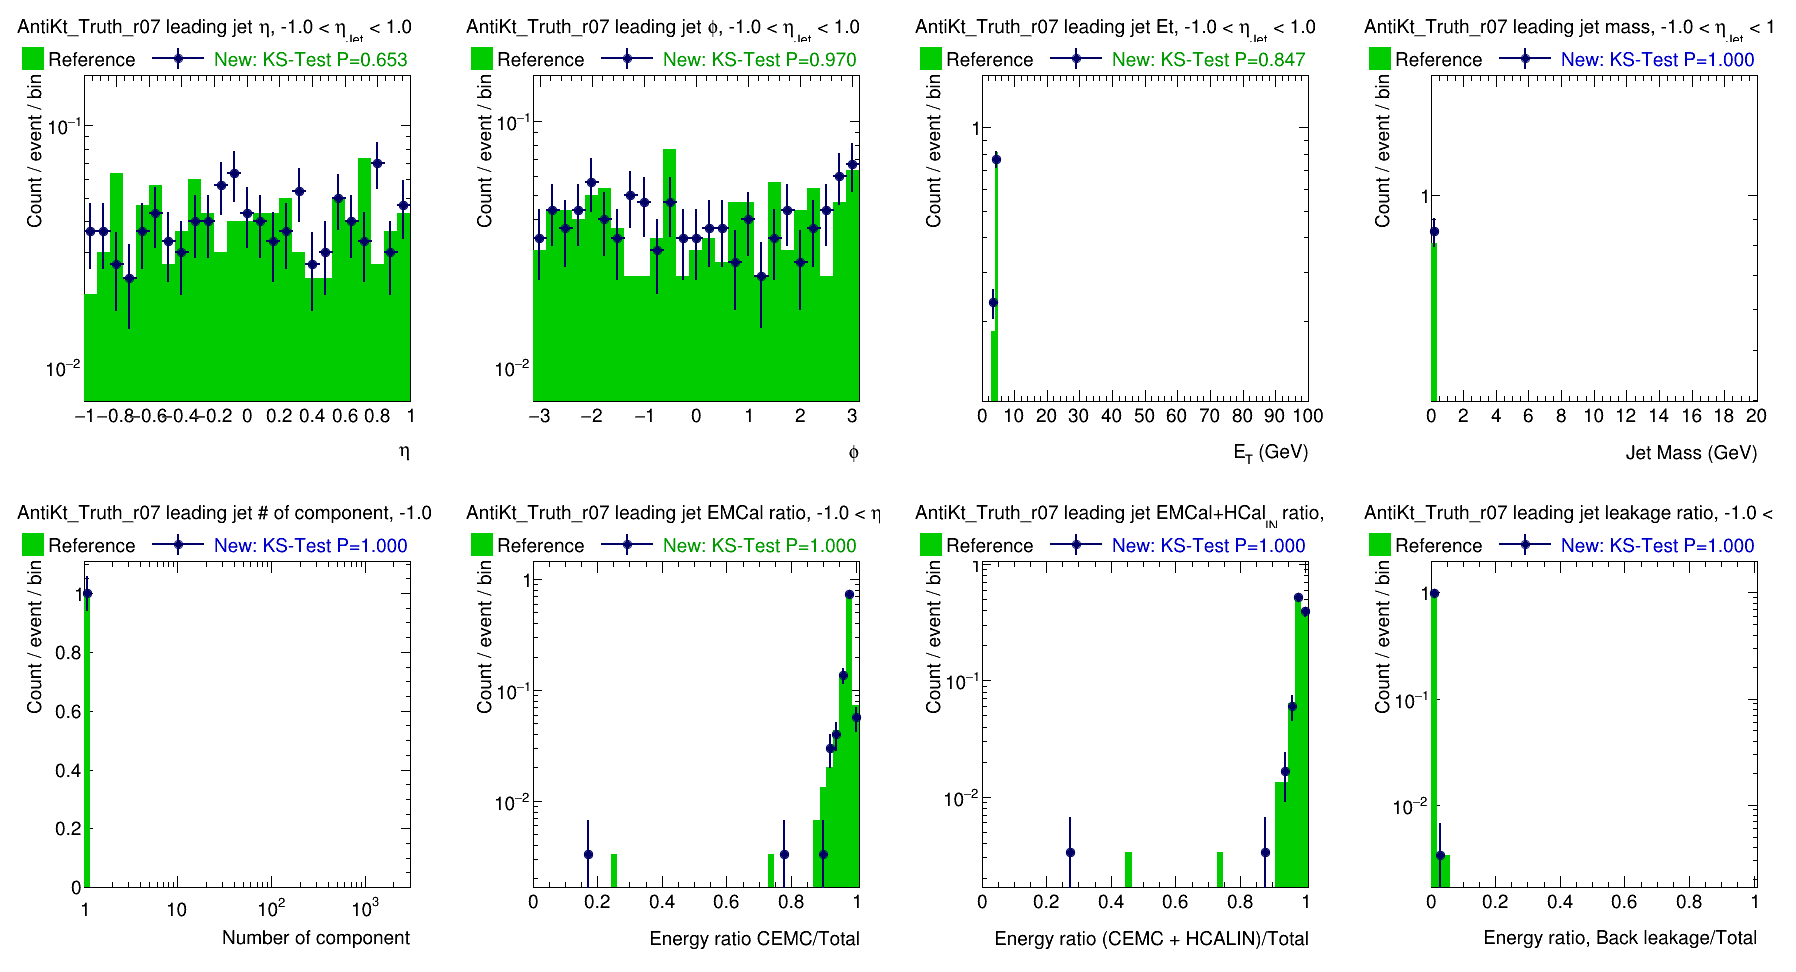

In [12]:
%%cpp

QA_Draw_Jet_Spectrum("h_QAG4SimJet_AntiKt_Truth_r07");
